In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [3]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/gdrive/MyDrive/CMPE257/data_aug_10.json"

(3660, 130, 13, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                     

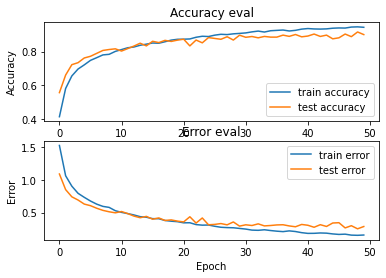

115/115 - 1s - loss: 0.3133 - accuracy: 0.8954 - 640ms/epoch - 6ms/step

Test accuracy: 0.8953551650047302
Target: 4, Predicted label: [4]


In [4]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    print(X_test.shape)
    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(5, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)




In [5]:
import json
import os
import math
import librosa

SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    
    signal, sample_rate = librosa.load(path, sr=SAMPLE_RATE)


    # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc
        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
           
    return data      

In [6]:
!pip install gradio

     |████████████████████████████████| 5.2 MB 5.0 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 2.0 MB 55.2 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 76.0 MB/s 
     |████████████████████████████████| 212 kB 74.0 MB/s 
     |████████████████████████████████| 253 kB 78.5 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 73.9 MB/s 
     |████████████████████████████████| 144 kB 74.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 11.1 MB 69.8 MB/s 
     |████████████████████████████████| 80 kB 8.8 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 4.0 MB 68.9 MB/s 
     |████████████████████████████████| 856 kB 71.5 MB/s 
     |██████████████████████

In [7]:
import gradio as gr

In [8]:
def predict_audio(path):
  MFCC = save_mfcc(path, num_segments=10)
  X = np.array(MFCC["mfcc"])
  X = X[...,np.newaxis]
  print(X)
  prediction = model.predict(X)
  print(prediction)
  map = {0:"BrunoMars",
         1: "Greenday",
         2:  "Migos",
         3:  "Beyonce",
         4:  "Maroon5"}
  predicted_index = np.argmax(prediction, axis=1)
  print(predicted_index)
  import statistics as st
  ans = map[st.mode(predicted_index)]
  return ans

In [ ]:
from IPython.lib.display import Audio
a = gr.inputs.Audio(source="upload", type="filepath", label=None, optional=False)
label = gr.outputs.Label(num_top_classes=5)

gr.Interface(fn=predict_audio, inputs=a, outputs=label,interpretation='default').launch(debug='True')

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://20030.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


[[[[-6.79942017e+01]
   [ 7.54739227e+01]
   [-3.47425423e+01]
   ...
   [-6.71049786e+00]
   [ 1.62146606e+01]
   [-1.23167419e+01]]

  [[-6.00034103e+01]
   [ 7.65179901e+01]
   [-3.62555313e+01]
   ...
   [-1.09847984e+01]
   [ 8.22433758e+00]
   [-7.67877245e+00]]

  [[-4.07684593e+01]
   [ 7.49634552e+01]
   [-2.97763748e+01]
   ...
   [-4.89207411e+00]
   [-1.50294018e+00]
   [-3.65358901e+00]]

  ...

  [[-4.24233398e+01]
   [ 5.87227554e+01]
   [-2.43932509e+00]
   ...
   [ 4.65984631e+00]
   [-4.08983660e+00]
   [-7.62206936e+00]]

  [[-7.45321655e+01]
   [ 7.50739059e+01]
   [ 1.55071616e-01]
   ...
   [ 1.41157150e+01]
   [ 3.01448345e+00]
   [-7.51834011e+00]]

  [[-1.03078033e+02]
   [ 8.95951309e+01]
   [ 3.67968106e+00]
   ...
   [ 2.04969521e+01]
   [ 1.59966507e+01]
   [-6.16285706e+00]]]


 [[[-1.15934349e+02]
   [ 9.73279266e+01]
   [-4.21556854e+00]
   ...
   [ 1.10407734e+00]
   [ 1.92347088e+01]
   [-7.72920036e+00]]

  [[-1.14658913e+02]
   [ 1.10811424e+02]
   [

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 275, in predict
    output = await app.blocks.process_api(body, username, session_state)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 274, in process_api
    predictions = await run_in_threadpool(block_fn.fn, *processed_input)
  File "/usr/local/lib/python3.7/dist-packages/starlette/concurrency.py", line 41, in run_in_threadpool
    return await anyio.to_thread.run_sync(func, *args)
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface

[[[[  15.19284916]
   [ 124.77639771]
   [ -31.04622459]
   ...
   [   7.30413818]
   [  -0.29373562]
   [  -3.18758249]]

  [[  13.52444744]
   [ 125.29124451]
   [ -28.64129257]
   ...
   [   6.18793392]
   [  -0.98780847]
   [   0.86840272]]

  [[  11.81113815]
   [ 120.52031708]
   [ -28.31919479]
   ...
   [   5.75375843]
   [  -3.28087234]
   [   1.15619671]]

  ...

  [[  20.61646271]
   [  91.3130188 ]
   [  -8.9426136 ]
   ...
   [  -4.78328514]
   [ -16.34807587]
   [  -2.3018918 ]]

  [[  35.4743042 ]
   [ 100.1202774 ]
   [   1.37599552]
   ...
   [  -8.92481613]
   [ -11.05027199]
   [  -1.51047981]]

  [[  32.51374435]
   [ 109.19747162]
   [   2.65825176]
   ...
   [ -13.29748917]
   [   2.42516232]
   [  -1.14790297]]]


 [[[  41.82758331]
   [ 105.11819458]
   [  -4.57019711]
   ...
   [ -12.50262833]
   [   7.37684822]
   [  -7.78922176]]

  [[  40.40004349]
   [ 106.33737946]
   [ -11.0216713 ]
   ...
   [  -7.73488426]
   [   4.32296991]
   [ -13.41895866]]

  [[  2